## Here we are going to be giving an attempt at the basic texture synthesis paper implementation with TensorFlow. I am doing this as a first step in understanding implementation. I have read up to the 2017 paper regarding Arbitrary Style transfer and think that before I start implementing a network like that its best to first start at something a bit more simple to get a feel for whats going on!

First lets take a look at the image we are going to be trying to derive the texture from.

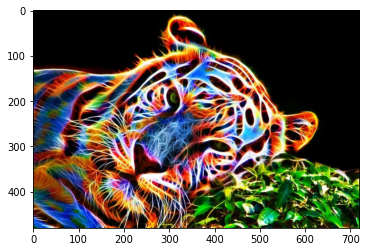

In [1]:
import matplotlib.pyplot as plt 
import matplotlib.image as image 
tiger = image.imread('/content/tigerimage.jpg')
plt.imshow(tiger)

Now lets begin the more intense part of the process!

First we need to load the pretrained vgg 16 model (without FC layers) that we are going to extract the feature statistics from (The gram matrix)

In [2]:
import tensorflow as tf 
from tensorflow.keras.applications.vgg16 import VGG16
base_model = VGG16(weights = 'imagenet', include_top=False)
tigerimage = tf.keras.utils.load_img(path = '/content/tigerimage.jpg', target_size=(224, 224, 3))

58900480/58889256 [==============================] - 0s 0us/step


In [3]:
tigerimage = tf.keras.utils.img_to_array(tigerimage)

In [4]:
tigerimage.shape

(224, 224, 3)

Lets not forget that although we have proper dimensionality, tensorflow models expect the first dimension to specify how many instances are in this 'batch', here its clearly just one.

In [5]:
tigerimage = tf.expand_dims(tigerimage, axis = 0)

In [6]:
tigerimage.shape

TensorShape([1, 224, 224, 3])

In [34]:
convout = ['block1_conv1','block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']

In [37]:
FeatureModel = tf.keras.Model(inputs = base_model.inputs, outputs = [base_model.get_layer(layers).output for layers in convout])

#Now that we have our feature extraction setup, above...
We need to now focus on creating a noise variable that we can train,then make a loss function(gram matrix) pick an optimizer, then decide on the number of iterations.
 

In [38]:
NoiseModel = FeatureModel

In [39]:
dummyvar = FeatureModel.predict(tigerimage)

In [40]:
len(dummyvar) #Ok so it seems like we are getting the 5 proper outputs, now lets check the sizes of these outputs to make
#sure its right

5

In [41]:
FeatureModel.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0   

In [13]:
for i in range(5):
  print(dummyvar[i].shape) #As we can see this is working out since the shapes are matching! the summary above

(1, 224, 224, 64)
(1, 112, 112, 128)
(1, 56, 56, 256)
(1, 28, 28, 512)
(1, 14, 14, 512)


Lets make sure our NoiseModel is also working properly

In [14]:
dummyvar1 = NoiseModel.predict(tigerimage)

In [15]:
len(dummyvar1)

5

In [16]:
for i in range(5):
  print(dummyvar1[i].shape) #Yep this matches the above which indicates we are ready to go.
  #Note that for the noise model the input shape can be different so long as channels match because 
  #for us to compute the gram matrix we reshape matrices so channels go first before height, width, and batch
  #then we squeeze the batch since its 1, and then reshape height and width to go together

(1, 224, 224, 64)
(1, 112, 112, 128)
(1, 56, 56, 256)
(1, 28, 28, 512)
(1, 14, 14, 512)


Now lets initialize a noise variable that we are going to update with the gradient.

In [181]:
random_initializer = tf.random_normal_initializer()
noiseVariable = tf.random.normal(shape=(224,224,3))
noiseVariable = tf.expand_dims(noiseVariable, axis = 0)
noiseVariable

<tf.Tensor: shape=(1, 224, 224, 3), dtype=float32, numpy=
array([[[[ 0.21198769, -0.67310315,  0.5171649 ],
         [ 1.5928323 ,  1.1066439 , -0.46945792],
         [ 0.38165578,  0.6727599 ,  0.30411953],
         ...,
         [ 0.02753794, -1.3986486 ,  0.17256019],
         [ 0.4451547 , -0.13080902,  0.8907668 ],
         [ 1.3326123 , -1.9710102 , -0.4908621 ]],

        [[-0.19022757,  1.1098713 , -1.6019472 ],
         [-0.02099533,  0.3428694 ,  1.0354764 ],
         [-1.7984918 ,  0.90663594, -1.198232  ],
         ...,
         [-0.5513649 ,  0.1797228 , -0.4591371 ],
         [-1.0711553 ,  0.32743785, -0.95744085],
         [ 1.3758126 ,  1.1704367 ,  0.162237  ]],

        [[-0.08109384, -0.69210494, -0.26801607],
         [-0.5927632 , -0.3353094 ,  1.995786  ],
         [ 1.7879078 , -0.79579914,  0.00543338],
         ...,
         [ 0.32346815,  1.1806267 ,  1.1966954 ],
         [ 0.22326468, -0.33107966, -0.7626797 ],
         [ 1.6428751 ,  0.2991028 ,  0.3892218

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


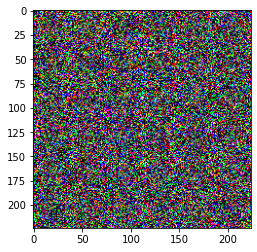

In [182]:
noisee = tf.random.normal(shape=(224, 224, 3))
plt.imshow(noisee)

Now lets pick an optimizer

In [18]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.0002)

In [158]:
from tensorflow.keras.applications.vgg16 import preprocess_input
noiseVariable = preprocess_input(noiseVariable)
tigerimage = preprocess_input(tigerimage)
noiseVariable = noiseVariable/255 
tigerimage = tigerimage/255

In [159]:
normalizer = tf.cast(tf.square(128)*tf.square(128)*4, dtype=tf.float32) #According to Paper
def Loss_Step(Noise, Feature):
  loss = tf.constant(0.0)
  NoisePredict= NoiseModel(Noise)
  FeaturePredict = FeatureModel(Feature)
  for i in range(len(NoisePredict)):
    NoisePredictt = tf.transpose(NoisePredict[i])
    FeaturePredictt = tf.transpose(FeaturePredict[i])
    NoisePred = tf.reshape(NoisePredictt, (NoisePredictt.shape[0], NoisePredictt.shape[1]*NoisePredictt.shape[2])) #(Channels, Vectorized(HW))
    FeaturePred = tf.reshape(FeaturePredictt, (FeaturePredictt.shape[0], FeaturePredictt.shape[1]*FeaturePredictt.shape[2]))
    NoiseGram = tf.linalg.matmul(NoisePred, NoisePred, transpose_b=True)
    FeatureGram = tf.linalg.matmul(FeaturePred, FeaturePred, transpose_b=True) 
    assert NoiseGram.shape == FeatureGram.shape 
    loss += tf.reduce_sum(tf.square(tf.subtract(FeatureGram, NoiseGram)))/(normalizer)
  return loss

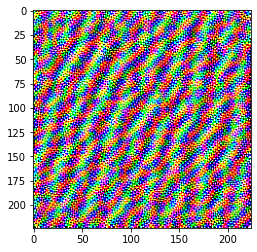

In [183]:
for i in range(1000):
  loss = tf.constant(0.0)
  with tf.GradientTape() as Tape:
    Tape.watch(noiseVariable)
    Loss = Loss_Step(noiseVariable, tigerimage)
  grad = Tape.gradient(Loss, noiseVariable)
  grad /= tf.math.reduce_std(grad) + 1e-8 
  noiseVariable += grad *.01
  noiseVariable = tf.clip_by_value(noiseVariable, -1, 1)
def deprocess(img):
  img = 255*(img + 1.0)/2.0
  return tf.cast(img, tf.uint8)
enhanced = deprocess(noiseVariable)
enhanced = tf.reshape(enhanced, (enhanced.shape[1], enhanced.shape[2], enhanced.shape[3]))
plt.imshow(enhanced)

In [169]:
noiseVariable = tf.reshape(noiseVariable, (noiseVariable.shape[1],noiseVariable.shape[2], noiseVariable.shape[3]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


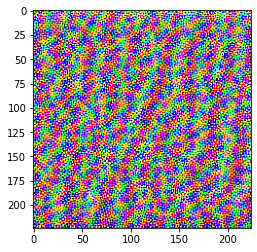

In [170]:
plt.imshow(noiseVariable)

In [29]:
iterations = 10000
def Training(iterations):
  loss = tf.constant(0.0)
  for i in range(iterations):
    with tf.GradientTape() as tape:
      tape.watch(noiseVariable)
      
      loss = Loss(noiseoutput, featureoutput)
    lossgrad = tape.gradient(loss, noiseVariable)
    Adam.apply_gradients(zip(lossgrad, noiseVariable))

In [70]:
import numpy as np
NoiseOut = NoiseModel.predict(noiseVariable)
FeatureOut = FeatureModel.predict(tigerimage)

In [119]:
for i in range(1):
  with tf.GradientTape() as Tape:
    
    Loss = tf.constant(0.0)
    Tape.watch(noiseVariable)
    Loss = Loss_Step(noiseVariable, tigerimage)
  print(Tape.gradient(Loss, noiseVariable), Loss, noiseVariable)

InvalidArgumentError: ignored